In [23]:
import importlib, sys, matplotlib.pyplot as plt, matplotlib.patheffects as pe
import sereias
import numpy as np
from astropy.io import fits

In [24]:
# Read the data cube to analyse
cube, info = sereias.read_fits_cube(
    "./datacube_reg1.fits",
    hdu=None,                     # or an index or ext name
    squeeze_singletons=True,
    slice_axes=None,              # e.g. {0:0} if there’s a Stokes axis first!
    assume_spectral_first=True,
)

In [25]:
# Perform segmentation directly from a numpy cube 
labels_final, info = sereias.starlet_segment_cube(
    cube, n_scales=4,
    positive=True, k_sigma=2.0,                 # decomposition
    # optional per-scale segmentation tweaks
    segmentation_params=dict(
        seed_quantile=0.95,
        cos_sim_min=0.80,
        min_region=10,
        normalize="unit",                        # spectra normalization
        connectivity=8,
    ),
    # fusion behavior
    fusion_method="argmax", 
    fusion_priority="fine_first",
    fusion_saliency_mode="l2",
    fusion_normalize="per",
    relabel_compact=True,
)

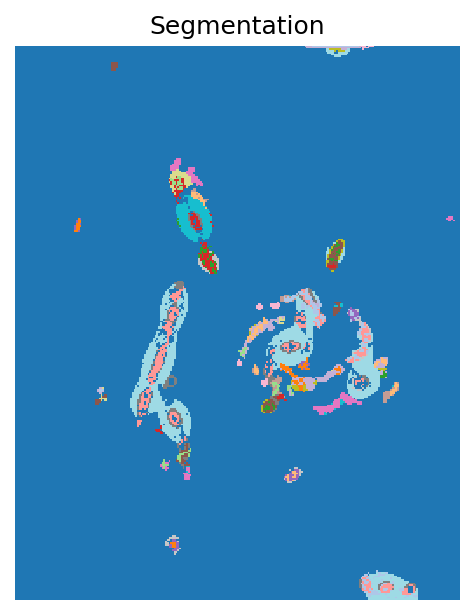

In [26]:
# Plot final segmentation...
plt.figure(dpi=150); 
plt.imshow(labels_final, interpolation="none", cmap="tab20"); plt.axis("off"); plt.title(f"Segmentation");

In [27]:
# Save resulting segmentation map to a fits file for the rest of the pipeline...
hdu = fits.PrimaryHDU(labels_final.astype(np.int32))
hdu.writeto("datacube_reg1_segmentationmap.fits", overwrite=True)

In [28]:
# Refinement step to 
labels_refined, refinfo = sereias.refine_labels_by_sed_adjacency(
    labels_final, cube,
    connectivity=4,      # or 4
    min_size=20,         # tweak based on your requirements
    sim_threshold=0.9,   # tighten/loosen as needed
    max_passes=3,
    prefer_larger=True,
    normalize="unit",    
    compact_ids=True,
    return_info=True,
)

print(refinfo)  # view how many merges/passes happened

{'passes': 3, 'merges': 72, 'sim_threshold': 0.9, 'connectivity': 4, 'min_size': 20}


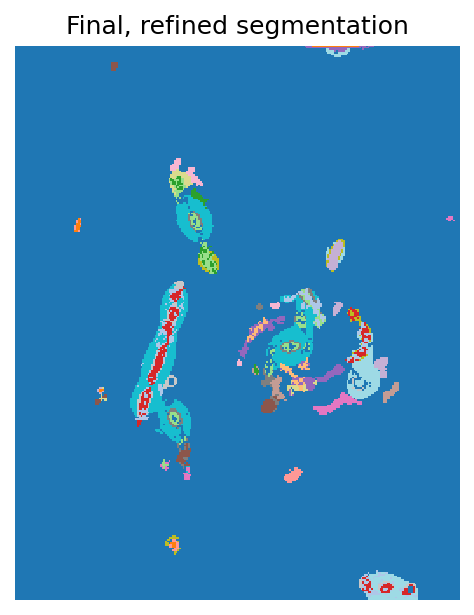

In [29]:
# Plot final segmentation after region refinement...
plt.figure(dpi=150); 
plt.imshow(labels_refined, interpolation="none", cmap="tab20"); plt.axis("off"); plt.title(f"Final, refined segmentation");